In [27]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
#dev-main

In [28]:
def get_code(black_part, code_list, convo):
    if len(black_part) > 0:
        # First delete top bar
        black_part.contents[0].decompose()
        # Then extract code text
        code = black_part.text
        splitted_code = code.split("\n")
        new_code = []
        for i in splitted_code:
            if len(i) != 0 and i[0] != "#":
                new_code.append(i)
        code = "\n".join(new_code)
                
        code_list.append(code)
        convo[0].contents[0].find_all("pre")[0].decompose()


In [29]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                # Search for code part of conversation
                black_part = convo[0].find_all("div", class_= "bg-black rounded-md")

                role = convo[0].get("data-message-author-role")
                code = ""
                # If there is a code part
                if len(black_part) > 0:
                    # First delete top bar
                    black_part[0].contents[0].decompose()
                    # Then extract code text
                    code = black_part[0].text
                    splitted_code = code.split("\n")
                    new_code = []
                    for i in splitted_code:
                        if len(i) != 0 and i[0] != "#":
                            new_code.append(i)
                    code = "\n".join(new_code)
                    # At the end delete code from text to create seperate things
                    convo[0].contents[0].find_all("pre")[0].decompose()
                
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text,
                        "code" : code
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:11<00:00, 11.00it/s]


In [30]:
#code2convos

In [31]:
# let's see one of the conversations
pprint(code2convos["f2f18684-4a16-4c05-a2d1-c0f96d1de869"][0])

{'code': '',
 'role': 'user',
 'text': 'How to handle missing values in a dataset in Python like a '
         'proficient data scientist?'}


In [32]:
# let's see one of the conversations
pprint(code2convos["f2f18684-4a16-4c05-a2d1-c0f96d1de869"][1])

{'code': 'import pandas as pd\nmissing_values = df.isnull().sum()',
 'role': 'assistant',
 'text': 'Handling missing values is a crucial step in the data preprocessing '
         'phase of any data science project. Dealing with missing data '
         'appropriately can significantly impact the performance and '
         'reliability of your models. Here are some common techniques you can '
         'use in Python to handle missing values like a proficient data '
         'scientist:Identify Missing Values:\n'
         "Before handling missing values, it's essential to identify where "
         'they exist in your dataset. You can use the isnull() method to '
         'identify missing values in a DataFrame.Remove Missing Values:\n'
         'If the number of missing values is relatively small, you may choose '
         'to remove the corresponding rows or columns. Use the dropna() method '
         'for this purpose.pythonCopy code# Remove rows with missing values\n'
         'df_clea

### Preprocess text data before feature engineering

In [33]:
# helper function for later use
def convert_list_to_str(my_list):
 
    list_to_str = ' '.join([str(elem) for i,elem in enumerate(my_list)])
    
    return list_to_str

In [34]:
def remove_html_tags(text):
    # Create a BeautifulSoup object
    soup = BeautifulSoup(text, "html.parser")

    # Extract text content without HTML tags
    clean_text = soup.get_text()

    return clean_text



In [35]:
"""for history, conversations in code2convos.items():
    for conversation in conversations:
        conversation["text"] = remove_html_tags(conversation["text"])
        conversation["code"] = [remove_html_tags(line) for line in conversation["code"]]"""

'for history, conversations in code2convos.items():\n    for conversation in conversations:\n        conversation["text"] = remove_html_tags(conversation["text"])\n        conversation["code"] = [remove_html_tags(line) for line in conversation["code"]]'

In [36]:
def remove_non_ascii(text):
    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

for code, convs in code2convos.items():
    for c in convs:
        c["text"] = remove_non_ascii(c["text"])

In [37]:
invalid_chats = []
for code, convs in code2convos.items():
    if len(convs) == 0:
        invalid_chats.append(code)
        

In [38]:
for chat_id in invalid_chats:
    print("deleting ", chat_id)
    del code2convos[chat_id]

deleting  139235c7-736c-4237-92f0-92e8c116832c
deleting  668ad17e-0240-49f7-b5a7-d22e502554c6
deleting  b0640e51-6879-40cb-a4f5-329f952ef99d
deleting  da6b70d5-29f6-491a-ad46-037c77067128


#### Preprocess scores dataset

In [39]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores

,Unnamed: 0,code,grade
0,0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0
...,...,...,...
140,140,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,89.0
141,141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0
142,142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0
143,143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0


In [40]:
duplicate = scores[scores.duplicated('code')]
duplicate

,Unnamed: 0,code,grade
6,6,dd898b12-b04b-404e-9b59-f846a162c177,98.0
11,11,dfe46143-c07c-4bb6-bddc-7458995dba2f,98.0
17,17,090d6217-5d69-4929-a342-19abab78324f,84.0
32,32,67c4a788-ec23-48c4-b6db-d76be6e118d6,86.0
38,38,fb8de815-224c-4d06-9fd4-7156d1a9920d,98.0
45,45,106ffe99-c787-4d09-9076-4ba411eb68b1,84.0
46,46,106ffe99-c787-4d09-9076-4ba411eb68b1,84.0
56,56,43ff9786-2b47-425b-8bad-e274d9988a0e,98.0
58,58,6b4e988c-eead-46ff-a35b-b2fd325b2698,78.0
73,73,663f8b4e-b683-4365-8316-b1dd1d325110,99.0


In [41]:
scores = scores.drop_duplicates(subset=['code'])
scores

,Unnamed: 0,code,grade
0,0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0
...,...,...,...
140,140,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,89.0
141,141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0
142,142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0
143,143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0


In [42]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 0 to 144
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   code        127 non-null    object 
 2   grade       126 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ KB


In [43]:
row_to_drop = scores[scores['grade'].isna()].copy()
print(row_to_drop)
scores.dropna(subset=['grade'], inplace=True)

    Unnamed: 0                                  code  grade
27          27  56c6f8dd-f37c-44d2-9820-9459aa34c8af    NaN


C:\Users\ahmet\AppData\Local\Temp\ipykernel_11484\314323257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.dropna(subset=['grade'], inplace=True)


In [44]:
del code2convos["56c6f8dd-f37c-44d2-9820-9459aa34c8af"]

In [45]:
condition = scores["code"].isin(invalid_chats)
# delete those rows
scores.drop(scores[condition].index, inplace=True)

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11484\498918818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.drop(scores[condition].index, inplace=True)


In [46]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 144
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  122 non-null    int64  
 1   code        122 non-null    object 
 2   grade       122 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ KB


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [47]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [48]:

questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [49]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [50]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,youve,ypred,yticklabels,yticks,zaman,zdm,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [52]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,youve,ypred,yticklabels,yticks,zaman,zdm,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5353)

In [54]:

code2prompts_tf_idf["f2f18684-4a16-4c05-a2d1-c0f96d1de869"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,youve,ypred,yticklabels,yticks,zaman,zdm,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
code2prompts_tf_idf["f2f18684-4a16-4c05-a2d1-c0f96d1de869"].shape

(71, 5353)

In [56]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [57]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [58]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153590,0.294806,0.521808,0.351954,0.460721,0.553786,0.167164,0.182873,0.195314
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.191945,0.795704,0.772039,0.882568,0.607164,0.987513,0.892523,0.570667,0.545559
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258138,0.295812,0.624688,0.351750,0.643210,0.454206,0.540143,0.546416,0.325708
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145873,0.117660,0.267496,0.316524,0.334208,0.315017,0.192578,0.261767,0.407476
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344148,0.575520,0.782747,0.624833,0.724887,0.872180,0.684591,0.945300,0.513217
...,...,...,...,...,...,...,...,...,...,...
117,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187288,0.209900,0.358634,0.211140,0.149090,0.507074,1.000000,0.862474,0.740103
118,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144671,0.139382,0.332093,0.950338,0.775874,0.828379,0.373992,0.905612,0.553940
119,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.210906,0.908754,0.977748,0.924269,0.888721,0.921350,0.779496,0.767344,0.500967
120,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173015,0.967366,1.000000,0.703792,0.942630,0.907420,1.000000,1.000000,0.784082


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [59]:
# import necessary libraries
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

New features
- #_hw_statements --> Useful to check if the student mentioned about the tass are for a homework in a Machine Learning course. ChatGPT may act accordingly when she knows the tasks will be presented in academy.

- #_question_statements --> The way the student behaves might affect the responses of ChatGPT.

- #_understand_statements --> If a students is eager to learn, it is more likely that she will use verbs like "explain". The more willingness to learn, the more likely to get a high grade. 

In [61]:
#Add new features
code2newfeatures = defaultdict(lambda : defaultdict(int))
hw_statements = ["machine learning", "course", "ML", "homework","cs", "assignment", "home work"]
question_statements = ["how", "why", "what", "where", "can you", "do you"]
understand_statements = ["explain", "reason", "example", "instance","demonstrate","describe", "proof" ,"prove","show", "I think"]
example_statements = ["for example", "for instance", "ex:", "here is an example", "see this", "like this", "similar to"]

hw_statements = [k.lower() for k in hw_statements]
question_statements = [q.lower() for q in question_statements]
understand_statements = [u.lower() for u in understand_statements]
example_statements = [n.lower() for n in example_statements]

for code, convs in code2convos.items():
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
                        
            # count the keywords
            for kw in hw_statements:
                code2newfeatures[code][f"#_hw_statements"] +=  len(re.findall(rf"\b{kw}\b", text))
            for qw in question_statements:
                code2newfeatures[code][f"#_question_statements"] +=  len(re.findall(rf"\b{qw}\b", text))
            for uw in understand_statements:
                code2newfeatures[code][f"#_understand_statements"] +=  len(re.findall(rf"\b{uw}\b", text))
            for nw in example_statements:
                code2newfeatures[code][f"#_example_statements"] +=  len(re.findall(rf"\b{uw}\b", text))

In [62]:
#Merge new features into features df
for code, features in code2newfeatures.items():
    for feature, value in features.items():
        code2features[code][feature] += value

In [63]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,2.200616,113.703886,0.0,13.0,6.0,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.304163,56.960730,1.0,9.0,3.0,0.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.249978,15.134767,0.0,7.0,3.0,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.123346,27.642008,0.0,10.0,1.0,0.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.017986,18.850776,1.0,40.0,10.0,7.0


- Average code length char by char

In [64]:
# count average code length in terms of number of chars in the code part of a response of ChatGPT

for code, convs in code2convos.items():
    num = 0
    total_sum = 0
    for c in convs:
        if c["role"] == "assistant":
            num += 1
            code_length_sum  = 0
            for line in c["code"]:
                code_length_sum  += len(line)
            total_sum += code_length_sum 
    code2features[code]["avg_code_length"] = (total_sum/num)
    code2features[code]["code_response_ratio"] = code2features[code]["avg_code_length"] / code2features[code]["response_avg_chars"]
    

In [65]:
#Finding number of imperative sentences given by the student
import spacy
import re

nlp = spacy.load("en_core_web_sm")  # Load the English NLP model once

def is_imperative(text):

    doc = nlp(text)

    # Check for common characteristics of imperative sentences:
    if len(doc) > 0:
        first_token = doc[0]

        # 1. Verb in imperative form at the beginning
        if first_token.pos_ == "VERB" and first_token.tag_ in ("VB", "VBP"):

            # 2. No subject or explicit subject
            if not first_token.dep_ or first_token.dep_ not in ("nsubj", "nsubjpass"):

                # 3. Handle exceptions and potential false positives:
                if not (first_token.text.lower() in ("let's", "let's") and doc[1].dep_ == "obj"):  # Exclude "Let's" suggestions
                    return True

    return False



nlp = spacy.load("en_core_web_sm")  # Load the English NLP model once for efficiency


for code, convos in code2convos.items():
    imperative_sentence_count = 0

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
        

            # Check for imperative sentences
            sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s", text)  # Split text into sentences
            for sentence in sentences:
                if is_imperative(sentence):
                    imperative_sentence_count += 1

    code2features[code]["imperative_sentence_count"] =  imperative_sentence_count




In [66]:
#for errors common word is "Traceback", we want to get # of errors that user dealt with

for code, convos in code2convos.items():
    traceback_count = 0

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
            traceback_count += text.count("Traceback")  # Count occurrences in user text

    code2features[code]["#given_errors"] = traceback_count





In [67]:
df = pd.DataFrame(code2features).T
df.head(5)


,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,2.200616,113.703886,0.0,13.0,6.0,0.0,648.285714,5.701526,18.0,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.304163,56.960730,1.0,9.0,3.0,0.0,430.611111,7.559789,20.0,0.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.249978,15.134767,0.0,7.0,3.0,0.0,305.222222,20.166959,14.0,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,0.123346,27.642008,0.0,10.0,1.0,0.0,512.500000,18.540621,1.0,0.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,0.017986,18.850776,1.0,40.0,10.0,7.0,480.476744,25.488433,27.0,6.0


In [68]:
#for students who get negative information gain and try to solve it

for code, convos in code2convos.items():
    neg_info_gain = False

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
            if (text.count("negative") > 0 and text.count("information gain") > 0):
                neg_info_gain = True
           

    code2features[code]["is_info_gain_negative"] = neg_info_gain

- total number of sentences in prompts
- average number of sentences in prompts

In [69]:
# count the number of sentences in a prompt

def count_sentences(text):
    
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Return the count of sentences
    return len(sentences)



In [70]:
# example usage

text = """My dataset is 3425x11. How should I set max_depth and min_samples_split lists? # param_grid represents the hyperparameters we want to try (our search space)
param_grid = {
    'max_depth': [3, 5, 8, 12, 16],
    'min_samples_split': [5, 8, 14, 20]
}

# estimator is the model we are evaluating, Decision Tree in our case
estimator = DecisionTreeClassifier(criterion='entropy', random_state=42)

# scoring is the score used to choose the best model
scoring='accuracy'

# cv is the number of folds to use for cross validation
cv = 5

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv)

grid_search.fit(X_train, y_train)"""

sentence_count = count_sentences(text)
print(f"Number of sentences: {sentence_count}")

Number of sentences: 3


##### Although the number of chars is quite high, the number of sentences is small. This is because the last part is actually a code snippet. 

In [71]:
for code, convs in code2convos.items():
    sentence_count = 0
    num = 0
    for c in convs:
        if c["role"] == "user":
            num += 1
            sentence_count += count_sentences(c["text"])
    code2features[code]["avg_sentences_in_prompts"] = (sentence_count/num)
    code2features[code]["#sentences_in_prompts"] = sentence_count


In [72]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts
0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,6,0,648.285714,5.701526,18,0,False,4.285714,60
0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,3,0,430.611111,7.559789,20,0,False,3.0,54
041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,3,0,305.222222,20.166959,14,0,False,5.888889,53
04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,1,0,512.5,18.540621,1,0,False,1.3,26
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,10,7,480.476744,25.488433,27,6,False,1.802326,155


##### We observed that some students provide the dataset to ChatGPT. We can check whether it has an impact on the grade. If it is provided, it is done in the top 10 prompts. Let's check them

In [73]:
dataset_keywords = ["Island where the penguin was found (Biscoe, Dream, Torgensen)", "cs412_hw1_dataset.csv", "https://www.kaggle.com/datasets/samybaladram/palmers-penguin-dataset-extended/data", "species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,diet,life_stage,health_metrics,year"]


for code, convs in code2convos.items():
    is_dataset_mentioned = any(
        any(keyword in conv["text"] for keyword in dataset_keywords)
        for conv in convs[:10] if conv["role"] == "user"
    )
    code2features[code]["is_dataset_given"] = is_dataset_mentioned


In [74]:
df = pd.DataFrame(code2features).T

In [75]:
print(df["is_dataset_given"].value_counts())
print("--------------------------------------")
df.head(5)

is_dataset_given
False    65
True     57
Name: count, dtype: int64
--------------------------------------


,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts,is_dataset_given
0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,6,0,648.285714,5.701526,18,0,False,4.285714,60,True
0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,3,0,430.611111,7.559789,20,0,False,3.0,54,True
041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,3,0,305.222222,20.166959,14,0,False,5.888889,53,True
04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,1,0,512.5,18.540621,1,0,False,1.3,26,False
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,10,7,480.476744,25.488433,27,6,False,1.802326,155,True


- Checking diverse similarities

In [76]:
# get the provided codes from ChatGPT to the students who took 100 points

stu_w_100 = scores[scores["grade"] == 100]
stu_w_100

,Unnamed: 0,code,grade
9,9,ba18e4e8-2c26-46d4-ba31-cc21947aabd5,100.0
12,12,58bee29c-a749-463e-8d56-c4edf0815b3f,100.0
26,26,51f35201-da77-4b6d-a455-99cc84195c5c,100.0
50,50,223ae726-cb25-49df-a125-c4af3519c8e8,100.0
51,51,e264c424-a241-43f7-acca-9fbbf21dc1c6,100.0
59,59,f2f18684-4a16-4c05-a2d1-c0f96d1de869,100.0
62,62,c21be348-17bd-4fdd-88f5-137f6a13cdee,100.0
67,67,c91d6fef-baf5-4e77-8bfc-b14fb7fc770d,100.0
68,68,58fcd378-aa29-4067-813c-bb4de525428e,100.0
77,77,5a62a8ee-c67c-475e-bd85-cf6d83c90ea9,100.0


In [77]:
stu_w_100_codes = {}
for student, convs in code2convos.items():
    if student in stu_w_100["code"].values:
        student_codes = []
        for c in convs:
            if c["role"] == "assistant" and (len(c["code"]) > 0):
                student_codes.append(c["code"])
        stu_w_100_codes[student] = student_codes
print(len(stu_w_100_codes))

22


In [78]:
stu_codes = {}
for student, convs in code2convos.items():
    student_codes = []
    for c in convs:
        if c["role"] == "assistant" and (len(c["code"]) > 0):
            student_codes.append(c["code"])
    stu_codes[student] = student_codes
print(len(stu_codes))


122


In [79]:
#stu_codes["fb8de815-224c-4d06-9fd4-7156d1a9920d"]

In [80]:
stu_w_100_codes_list = []
for student in stu_w_100_codes:
    stu_w_100_codes_list.append(convert_list_to_str(stu_w_100_codes[student]))

print(len(stu_w_100_codes_list))
#print(stu_w_100_codes_list)

22


In [81]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_stu_w_100_codes = tfidf_vectorizer.fit_transform(stu_w_100_codes_list)

code_responses_similarity = {}
for student, code_respsonses in stu_codes.items():
    cur_stu_tf_idf = tfidf_vectorizer.transform([convert_list_to_str(stu_codes[student])])
    
    # Calculate cosine similarity with the TF-IDF of conversations who scored 100
    similarity_scores = cosine_similarity(cur_stu_tf_idf, tfidf_matrix_stu_w_100_codes)
    
    # We take the average similarity score for simplicity
    code_responses_similarity[student] = similarity_scores.mean()

similarity_with_stu_w_100_codes_df = pd.DataFrame.from_dict(code_responses_similarity, orient='index', columns=['similarity_with_stu_w_100_codes'])


similarity_with_stu_w_100_codes_df = similarity_with_stu_w_100_codes_df.reset_index()

similarity_with_stu_w_100_codes_df.columns = ['student', 'similarity_with_stu_w_100_codes']

similarity_with_stu_w_100_codes_df.head(10)


,student,similarity_with_stu_w_100_codes
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.388900
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.284869
2,041f950b-c013-409a-a642-cffff60b9d4b,0.161327
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.397671
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.376866
5,090d6217-5d69-4929-a342-19abab78324f,0.397424
6,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,0.458354
7,0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc,0.344628
8,0e466794-f7f8-4cc2-b07e-070b13a0b5e1,0.403641
9,0f0c953a-a472-47c1-809b-9fc14dba9091,0.239911


In [82]:

scores.drop(columns=['Unnamed: 0'], inplace=True)#Cause conflict when merging with df
scores

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11484\2613183846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores.drop(columns=['Unnamed: 0'], inplace=True)#Cause conflict when merging with df


,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0
...,...,...
140,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,89.0
141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0
142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0
143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0


In [83]:
df = df.reset_index()
df = df.rename(columns={"index": "code"})

In [84]:
df

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts,is_dataset_given
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,6,0,648.285714,5.701526,18,0,False,4.285714,60,True
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,3,0,430.611111,7.559789,20,0,False,3.0,54,True
2,041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,3,0,305.222222,20.166959,14,0,False,5.888889,53,True
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,1,0,512.5,18.540621,1,0,False,1.3,26,False
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,10,7,480.476744,25.488433,27,6,False,1.802326,155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,f24219d6-07f0-4baf-80ac-18475dc5b66f,21,1,0,0,0,0.118153,40.575226,4,9,2,0,277.142857,6.830347,9,0,False,2.0,42,True
118,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71,1,1,1,1,0.119424,8.186395,0,29,15,14,268.746479,32.828429,15,1,False,1.859155,132,False
119,f852596d-fdca-45aa-9050-d4f76ce6a53c,30,6,1,0,4,0.104486,22.204953,0,19,9,0,402.433333,18.123584,17,3,False,2.866667,86,True
120,f8ec3336-fd48-4654-ad98-62ccfb96d096,14,0,0,0,1,0.124106,107.207571,1,5,3,7,332.0,3.096796,7,0,False,3.5,49,False


In [85]:

temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")

#temp_df=df

temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts,is_dataset_given,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,...,0,648.285714,5.701526,18,0,False,4.285714,60,True,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,...,0,430.611111,7.559789,20,0,False,3.0,54,True,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,...,0,305.222222,20.166959,14,0,False,5.888889,53,True,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,...,0,512.5,18.540621,1,0,False,1.3,26,False,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,...,7,480.476744,25.488433,27,6,False,1.802326,155,True,100.0


Playground for Similarity with the ones who got 100

--------------------------------------------------------------------
To be used in bonus part

In [86]:
stu_w_100_prompts = {}
for student, convs in code2convos.items():
    if student in stu_w_100["code"].values:
        student_prompts = []
        for c in convs:
            if c["role"] == "user" and (len(c["text"]) > 0):
                student_prompts.append(c["text"])
        stu_w_100_prompts[student] = student_prompts
print(len(stu_w_100_prompts))

22


In [87]:
stu_w_100_prompts_list = []
for student in stu_w_100_codes:
    stu_w_100_prompts_list.append(convert_list_to_str(stu_w_100_prompts[student]))

print(len(stu_w_100_prompts_list))

22


--------------------------------------------------------------------

In [88]:
#tf-ıdf vectorizer with only user prompts
conversations_100 = []
for code, convos in code2convos.items():
    # Check if the code exists in temp_df and if the student scored 100
    if code in temp_df['code'].values and temp_df.loc[temp_df['code'] == code, 'grade'].values[0] == 100:
        convo_text = " ".join(c["text"] for c in convos if c["role"] == "user")
        conversations_100.append(convo_text)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_100 = tfidf_vectorizer.fit_transform(conversations_100)

code2similarity = {}
for code, convos in code2convos.items():
    # Extract the text for the current student's conversation
    student_convo = " ".join(c["text"] for c in convos if c["role"] == "user")
    
    # Vectorize the current student's conversation using the TF-IDF model created earlier
    student_tfidf = tfidf_vectorizer.transform([student_convo])
    
    # Calculate cosine similarity with the TF-IDF of conversations who scored 100
    similarity_scores = cosine_similarity(student_tfidf, tfidf_matrix_100)
    
    # We take the average similarity score for simplicity
    code2similarity[code] = similarity_scores.mean()

# Step 4: Store these similarities in a new DataFrame
similarity_df = pd.DataFrame.from_dict(code2similarity, orient='index', columns=['similarity_with_100'])


similarity_df = similarity_df.reset_index()

# Rename columns appropriately
similarity_df.columns = ['code', 'similarity_with_100']

# Now similarity_df_reset has a regular index and separate columns for 'code' and 'similarity_with_100'
similarity_df.head()


,code,similarity_with_100
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.558833
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.645824
2,041f950b-c013-409a-a642-cffff60b9d4b,0.647879
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.516610
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.622495


In [89]:
#tf-ıdf vectorizer with user and assistant convos
conversations_100 = []
for code, convos in code2convos.items():
    # Check if the code exists in temp_df and if the student scored 100
    if code in temp_df['code'].values and temp_df.loc[temp_df['code'] == code, 'grade'].values[0] == 100:
        convo_text = " ".join(c["text"] for c in convos if c["role"] == "user" or c["role"] == "assistant")
        conversations_100.append(convo_text)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_100 = tfidf_vectorizer.fit_transform(conversations_100)

code2similarity = {}
for code, convos in code2convos.items():
    # Extract the text for the current student's conversation
    student_convo = " ".join(c["text"] for c in convos if c["role"] == "user" or c["role"] == "assistant")
    
    # Vectorize the current student's conversation using the TF-IDF model created earlier
    student_tfidf = tfidf_vectorizer.transform([student_convo])
    
    # Calculate cosine similarity with the TF-IDF of conversations who scored 100
    similarity_scores = cosine_similarity(student_tfidf, tfidf_matrix_100)
    
    # We take the average similarity score for simplicity
    code2similarity[code] = similarity_scores.mean()

# Step 4: Store these similarities in a new DataFrame
similarity_df2 = pd.DataFrame.from_dict(code2similarity, orient='index', columns=['similarity_with_100'])

similarity_df2.head(100)

similarity_df2 = similarity_df2.reset_index()

# Rename columns appropriately
similarity_df2.columns = ['code', 'similarity_with_100']

# Now similarity_df_reset has a regular index and separate columns for 'code' and 'similarity_with_100'
similarity_df2.head()

,code,similarity_with_100
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.848483
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.888370
2,041f950b-c013-409a-a642-cffff60b9d4b,0.831423
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.875375
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.896214


In [90]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import numpy as np
import pandas as pd
import re

# Step 1: Prepare the data for Word2Vec
# Tokenize the conversations
tokenized_conversations = []
for convos in code2convos.values():
    for c in convos:
        #if c['role'] == 'user' or c['role'] == 'assistant':  # Assuming you want to include only user's text
            # Tokenize the text and add to the list
        tokenized_conversations.append(c['text'].lower().split())

# Step 2: Train a Word2Vec model
# Here we are training a model on the tokenized conversations
word2vec_model = Word2Vec(sentences=tokenized_conversations, vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Calculate the mean vector for conversations of students who scored 100
# First, get the conversations for codes where the grade is 100
codes_with_grade_100 = temp_df[temp_df['grade'] == 100]['code']
conversations_100 = []

for code in codes_with_grade_100:
    convos = code2convos[code]
    for c in convos:
        if c['role'] == 'user':
            conversations_100.extend(c['text'].lower().split())

# Tokenize the conversations and filter out words not in the model's vocabulary
conversations_100 = [word for word in conversations_100 if word in word2vec_model.wv]

# Calculate the mean vector for these words
mean_vector_100 = np.mean([word2vec_model.wv[word] for word in conversations_100], axis=0)

# Step 4: Compare each student's conversation with the mean vector
code2similarity = defaultdict(float)

for code, convos in code2convos.items():
    all_words = []
    for c in convos:
        if c['role'] == 'user':
            all_words.extend(c['text'].lower().split())
    
    valid_words = [word for word in all_words if word in word2vec_model.wv]
    
    if not valid_words:  # Skip if there are no valid words
        continue
    
    student_convo_vector = np.mean([word2vec_model.wv[word] for word in valid_words], axis=0)
    
    similarity_score = cosine_similarity([student_convo_vector], [mean_vector_100])[0][0]
    
    code2similarity[code] = similarity_score

# Step 5: Convert the similarity scores to a DataFrame
similarity_df_v2v = pd.DataFrame(list(code2similarity.items()), columns=['code', 'similarity_with_100_word2vec'])

similarity_df_v2v.head(100)




,code,similarity_with_100_word2vec
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.908001
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.971163
2,041f950b-c013-409a-a642-cffff60b9d4b,0.978980
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.947601
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.985750
...,...,...
95,b73f91f8-732f-4a48-bcbd-eadbbb457a94,0.989709
96,ba18e4e8-2c26-46d4-ba31-cc21947aabd5,0.962845
97,c0f51763-0c69-45fb-a4d7-6906d53db43d,0.796337
98,c21be348-17bd-4fdd-88f5-137f6a13cdee,0.970257


##### Let's compare different approaches for a data point

In [91]:


# Define the target code you want to print
your_target_code = '089eb66d-4c3a-4f58-b98f-a3774a2efb34'

# Locate the row with the target code in the DataFrame
target_row = similarity_df.loc[similarity_df['code'] == your_target_code]
target_row2 = similarity_df2.loc[similarity_df['code'] == your_target_code]
target_rowv2v = similarity_df_v2v.loc[similarity_df['code'] == your_target_code]

# Check if the target code exists in the DataFrame
if not target_row.empty:
    # Print the row containing the target code
    print(target_row)
    print(target_row2)
    print(target_rowv2v)
else:
    print("Target code not found in the similarity_df.")


                                   code  similarity_with_100
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34             0.622495
                                   code  similarity_with_100
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34             0.896214
                                   code  similarity_with_100_word2vec
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34                       0.98575


In [92]:

scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11484\464382408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["code"] = scores["code"].apply(lambda x: x.strip())


,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


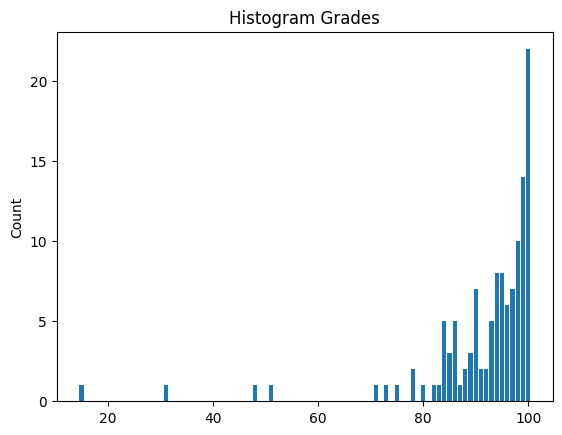

In [93]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

#### Merging scores with features

In [94]:
temp_df = pd.merge(temp_df, question_mapping_scores, on="code", how="left")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,grade,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,...,48.0,0.153590,0.294806,0.521808,0.351954,0.460721,0.553786,0.167164,0.182873,0.195314
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,...,99.0,0.191945,0.795704,0.772039,0.882568,0.607164,0.987513,0.892523,0.570667,0.545559
2,041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,...,90.0,0.258138,0.295812,0.624688,0.351750,0.643210,0.454206,0.540143,0.546416,0.325708
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,...,97.0,0.145873,0.117660,0.267496,0.316524,0.334208,0.315017,0.192578,0.261767,0.407476
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,...,100.0,0.344148,0.575520,0.782747,0.624833,0.724887,0.872180,0.684591,0.945300,0.513217


In [95]:
# Merge temp_df with similarity_df on the 'code' column

#first update the column name
similarity_df.rename(columns={'similarity_with_100': 'similarity_with_stu_w_100_prompts'}, inplace=True)
temp_df = pd.merge(temp_df, similarity_df, on='code', how='left')

# Display the first few rows of the merged dataframe
temp_df.head()


,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,...,0.153590,0.294806,0.521808,0.351954,0.460721,0.553786,0.167164,0.182873,0.195314,0.558833
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,...,0.191945,0.795704,0.772039,0.882568,0.607164,0.987513,0.892523,0.570667,0.545559,0.645824
2,041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,...,0.258138,0.295812,0.624688,0.351750,0.643210,0.454206,0.540143,0.546416,0.325708,0.647879
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,...,0.145873,0.117660,0.267496,0.316524,0.334208,0.315017,0.192578,0.261767,0.407476,0.516610
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,...,0.344148,0.575520,0.782747,0.624833,0.724887,0.872180,0.684591,0.945300,0.513217,0.622495


In [96]:
# Merge temp_df with similarity_with_stu_w_100_codes_df on the 'code' column

#first update the column name
similarity_with_stu_w_100_codes_df.rename(columns={'student': 'code'}, inplace=True)
temp_df = pd.merge(temp_df, similarity_with_stu_w_100_codes_df, on='code', how='left')

# Display the first few rows of the merged dataframe
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts,similarity_with_stu_w_100_codes
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14,3,1,0,0,2.200616,113.703886,0,13,...,0.294806,0.521808,0.351954,0.460721,0.553786,0.167164,0.182873,0.195314,0.558833,0.388900
1,0225686d-b825-4cac-8691-3a3a5343df2b,18,0,0,0,0,0.304163,56.96073,1,9,...,0.795704,0.772039,0.882568,0.607164,0.987513,0.892523,0.570667,0.545559,0.645824,0.284869
2,041f950b-c013-409a-a642-cffff60b9d4b,9,3,0,1,0,0.249978,15.134767,0,7,...,0.295812,0.624688,0.351750,0.643210,0.454206,0.540143,0.546416,0.325708,0.647879,0.161327
3,04f91058-d0f8-4324-83b2-19c671f433dc,20,1,1,0,0,0.123346,27.642008,0,10,...,0.117660,0.267496,0.316524,0.334208,0.315017,0.192578,0.261767,0.407476,0.516610,0.397671
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86,1,5,0,0,0.017986,18.850776,1,40,...,0.575520,0.782747,0.624833,0.724887,0.872180,0.684591,0.945300,0.513217,0.622495,0.376866


#### Handling With Left Skewed Data

In [97]:
df = temp_df.copy()

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [99]:
df_transform = df.copy()
df_transform['grade_log'] = np.log1p(df_transform['grade'])
df_transform['grade_boxcox'], _ = boxcox(df_transform['grade']+1)
df_transform['grade_sqrt'] = np.sqrt(df_transform['grade'])

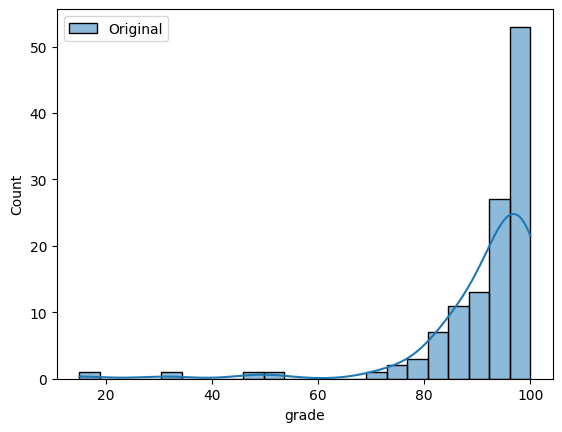

In [100]:
# Plot original and transformed distributions
sns.histplot(df_transform['grade'], kde=True, label='Original')
plt.legend()
plt.show()

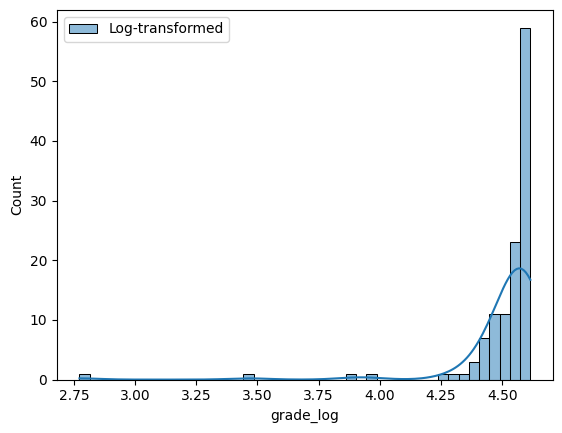

In [101]:
sns.histplot(df_transform['grade_log'], kde=True, label='Log-transformed')
plt.legend()
plt.show()

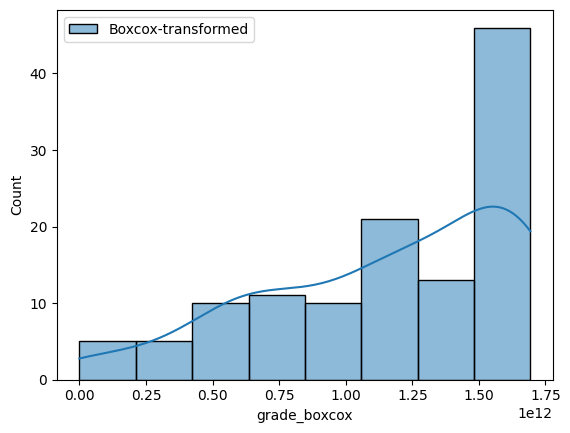

In [102]:
sns.histplot(df_transform['grade_boxcox'], kde=True, label='Boxcox-transformed')
plt.legend()
plt.show()

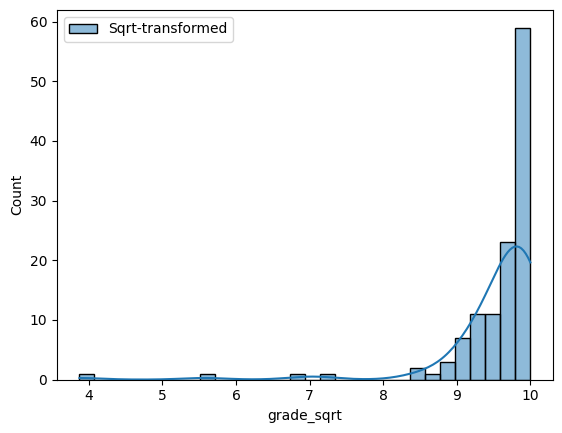

In [103]:
sns.histplot(df_transform['grade_sqrt'], kde=True, label='Sqrt-transformed')
plt.legend()
plt.show()

#### The grade distribution is closer to normal distribution when Boxcox transformation is applied.

#### Train/Test split

In [104]:
from sklearn.utils import shuffle

In [105]:
df_shuffled = shuffle(df, random_state=42)
cols_to_drop = ['grade', "code"]
X = df_shuffled.drop(cols_to_drop, axis=1)
y = df_shuffled['grade']


# Use stratified sampling in the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (96, 30)
X_test shape: (25, 30)
y_train shape: (96,)
y_test shape: (25,)


In [106]:
y_train_transformed, lambda_value = boxcox(y_train)

In [107]:
from sklearn.preprocessing import RobustScaler

# Robust scaling on the features
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)


## Features and Correlations

In [108]:
#copy df into check_df in order to transform obj->numeric
check_df = df.copy()

for col in check_df.columns:
    # Convert columns with 'object' dtype to numeric
    if check_df[col].dtype == 'object':
        check_df[col] = pd.to_numeric(check_df[col], errors='coerce')

# Now print the updated data types
print(check_df.dtypes)

code                                 float64
#user_prompts                          int64
#error                                 int64
#no                                    int64
#thank                                 int64
#next                                  int64
prompt_avg_chars                     float64
response_avg_chars                   float64
#_hw_statements                        int64
#_question_statements                  int64
#_understand_statements                int64
#_example_statements                   int64
avg_code_length                      float64
code_response_ratio                  float64
imperative_sentence_count              int64
#given_errors                          int64
is_info_gain_negative                   bool
avg_sentences_in_prompts             float64
#sentences_in_prompts                  int64
is_dataset_given                        bool
grade                                float64
Q_0                                  float64
Q_1       

In [109]:
#dropping code because it cannot be turned into numeric
check_df = check_df.drop(columns=['code'])
check_df

,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,...,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts,similarity_with_stu_w_100_codes
0,14,3,1,0,0,2.200616,113.703886,0,13,6,...,0.294806,0.521808,0.351954,0.460721,0.553786,0.167164,0.182873,0.195314,0.558833,0.388900
1,18,0,0,0,0,0.304163,56.960730,1,9,3,...,0.795704,0.772039,0.882568,0.607164,0.987513,0.892523,0.570667,0.545559,0.645824,0.284869
2,9,3,0,1,0,0.249978,15.134767,0,7,3,...,0.295812,0.624688,0.351750,0.643210,0.454206,0.540143,0.546416,0.325708,0.647879,0.161327
3,20,1,1,0,0,0.123346,27.642008,0,10,1,...,0.117660,0.267496,0.316524,0.334208,0.315017,0.192578,0.261767,0.407476,0.516610,0.397671
4,86,1,5,0,0,0.017986,18.850776,1,40,10,...,0.575520,0.782747,0.624833,0.724887,0.872180,0.684591,0.945300,0.513217,0.622495,0.376866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,21,1,0,0,0,0.118153,40.575226,4,9,2,...,0.209900,0.358634,0.211140,0.149090,0.507074,1.000000,0.862474,0.740103,0.613719,0.256404
117,71,1,1,1,1,0.119424,8.186395,0,29,15,...,0.139382,0.332093,0.950338,0.775874,0.828379,0.373992,0.905612,0.553940,0.506395,0.435356
118,30,6,1,0,4,0.104486,22.204953,0,19,9,...,0.908754,0.977748,0.924269,0.888721,0.921350,0.779496,0.767344,0.500967,0.638640,0.362500
119,14,0,0,0,1,0.124106,107.207571,1,5,3,...,0.967366,1.000000,0.703792,0.942630,0.907420,1.000000,1.000000,0.784082,0.517611,0.408639


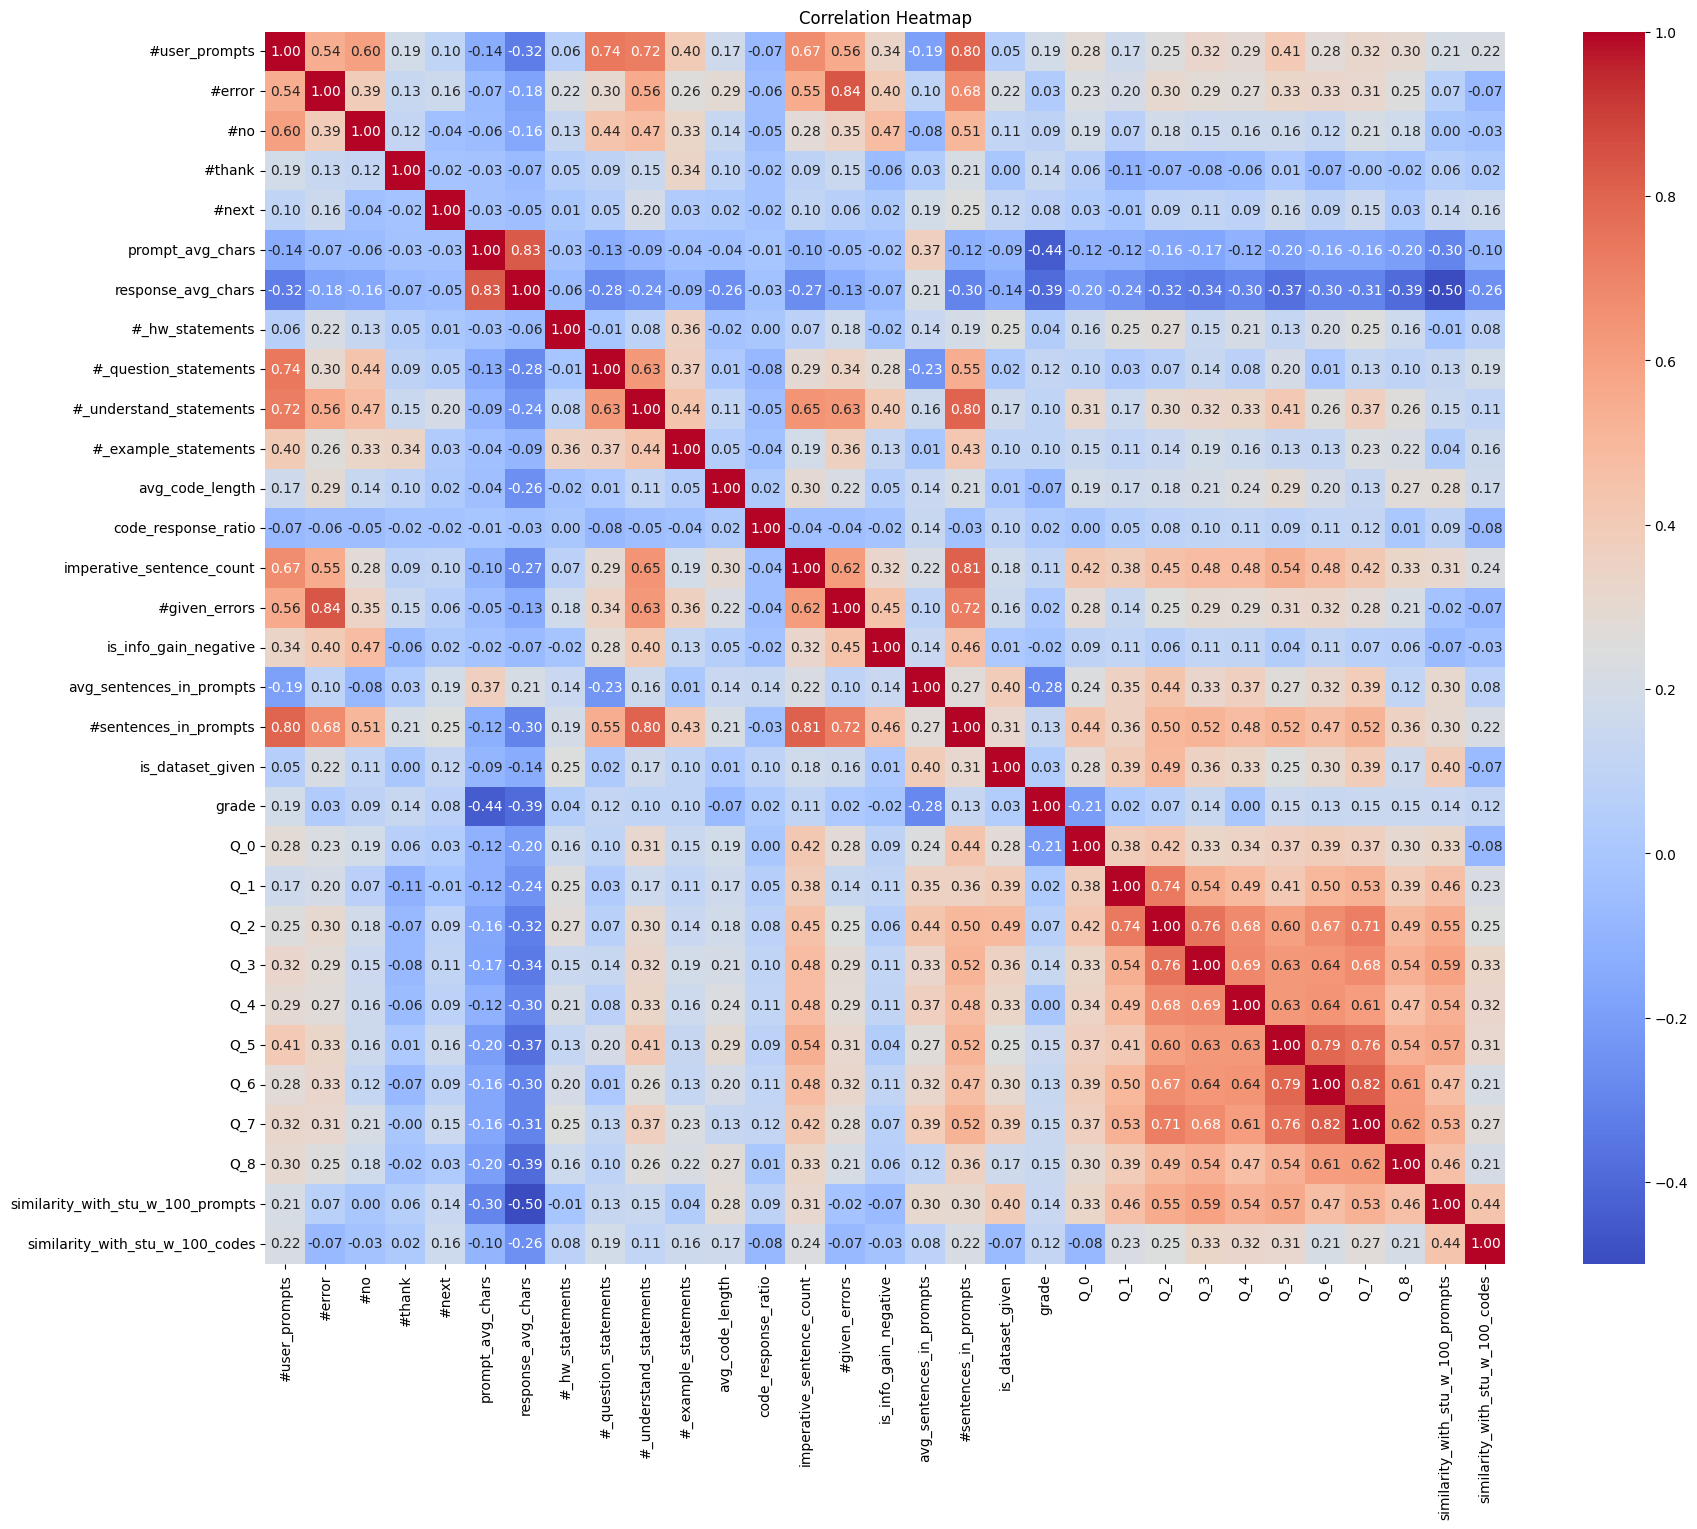

In [110]:
import seaborn as sns
correlation_matrix = check_df.corr()
target_correlation = correlation_matrix['grade'].sort_values(ascending=False)

# Plotting results in a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

correlation_matrix = check_df.corr()

In [111]:
print(target_correlation)

grade                                1.000000
#user_prompts                        0.190380
Q_5                                  0.151687
Q_7                                  0.150539
Q_8                                  0.148789
similarity_with_stu_w_100_prompts    0.144083
#thank                               0.137570
Q_3                                  0.137202
Q_6                                  0.134005
#sentences_in_prompts                0.132334
similarity_with_stu_w_100_codes      0.119490
#_question_statements                0.116649
imperative_sentence_count            0.105484
#_example_statements                 0.102930
#_understand_statements              0.099487
#no                                  0.088821
#next                                0.077246
Q_2                                  0.067168
#_hw_statements                      0.042252
is_dataset_given                     0.034918
#error                               0.028223
code_response_ratio               

### Dimensionality Reduction

In [112]:
from sklearn.preprocessing import RobustScaler
# Use a RobustScaler on the entire dataset
robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X)


In [113]:
from sklearn.decomposition import PCA


pca = PCA(n_components=len(df.columns) - 2)  # Create PCA with a maximum of 30 components
pca.fit(X_scaled)  # Fit PCA on the data
exp_var_ratio = pca.explained_variance_ratio_  # Get explained variance ratios

n_comps = 0
count_exp_var = 0

desired_var = 0.95
# Loop to find the number of components needed to reach desired variance
for i in exp_var_ratio:
    n_comps += 1
    count_exp_var += i
    if count_exp_var >= desired_var:
        break

print("Number of components needed:", n_comps)


Number of components needed: 1


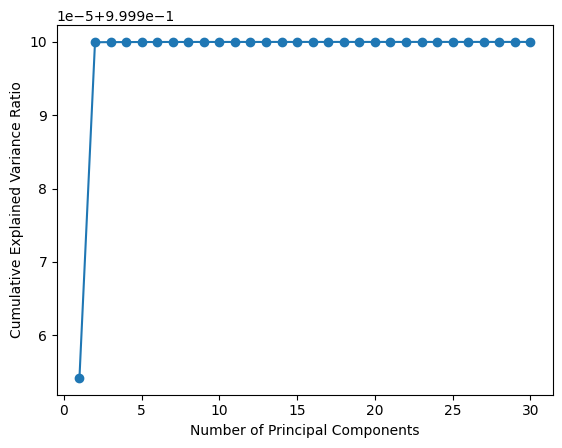

In [114]:
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

#### Good news. PC1 achieves 0.95 of variance.

In [115]:
# # Transform the training and testing sets
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [116]:
X_train_pure = X_train
y_train_pure = y_train

In [117]:
X_train = X_train_scaled 
y_train = y_train_transformed

In [118]:
#Hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and values to tune for regression
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)  # Replace X_train and y_train with your training data

# Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (Negative Mean Squared Error):", best_score)


Best Hyperparameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 15}
Best Score (Negative Mean Squared Error): -2.3148274039361276e+22


#### Fitting a model

#### Predicting and Analyzing 

In [119]:
max_depth = best_params["max_depth"]
min_samples_split = best_params["min_samples_split"]
max_features = best_params["max_features"]
min_samples_leaf = best_params["min_samples_leaf"]
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth = max_depth, min_samples_split = min_samples_split, max_features = max_features, min_samples_leaf = min_samples_leaf)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=6, min_samples_split=15,
                      random_state=0)

In [120]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 2.0191132627806435e+22
Node 1 has MSE 2.1211027970933234e+22
Node 2 has MSE 1.4633182366811151e+22
Node 3 has MSE 2.0589644075746363e+22
Node 4 has MSE 1.5195391000026949e+22
Node 5 has MSE 1.0177589642612384e+22
Node 6 has MSE 7.743267696195733e+21
Node 7 has MSE 1.4748500912458443e+22
Node 8 has MSE 2.0912914617258633e+22
Node 9 has MSE 1.035428985552122e+22
Node 10 has MSE 1.511504992040616e+22


In [121]:

feature_names = df.columns[1:-1]
feature_names

Index(['#user_prompts', '#error', '#no', '#thank', '#next', 'prompt_avg_chars',
       'response_avg_chars', '#_hw_statements', '#_question_statements',
       '#_understand_statements', '#_example_statements', 'avg_code_length',
       'code_response_ratio', 'imperative_sentence_count', '#given_errors',
       'is_info_gain_negative', 'avg_sentences_in_prompts',
       '#sentences_in_prompts', 'is_dataset_given', 'grade', 'Q_0', 'Q_1',
       'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8',
       'similarity_with_stu_w_100_prompts'],
      dtype='object')

In [ ]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=feature_names)
graph = graphviz.Source(dot_data)
graph.render("hw")

In [123]:
from scipy.special import inv_boxcox

In [124]:
# Prediction

# Transform the target variable of the test set
y_test_transformed = boxcox(y_test, lambda_value)

# Scale the features of the test set using the same scaler from training
X_test_scaled = robust_scaler.transform(X_test)

# Make predictions using the trained model
y_pred_transformed = regressor.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_original_scale = inv_boxcox(y_pred_transformed, lambda_value)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_original_scale)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred_original_scale)
print(f'R-squared: {r2}')


Mean Squared Error: 62.183024090539696
R-squared: -0.2850281066190752


In [125]:
#Gradient Boost and hyperparameter tuning 
from sklearn.ensemble import GradientBoostingRegressor
# Initialize the GradientBoostingRegressor
gb = GradientBoostingRegressor()

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [126]:


# Define the parameters for the Gradient Boosting model
params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 200
}

best = grid_search.best_params_

# Create a Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(learning_rate = best['learning_rate'], max_depth = best['max_depth'], min_samples_split = best['min_samples_split'], min_samples_leaf = best['min_samples_leaf'], n_estimators = best['n_estimators'])

# Train the model
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=4,
                          min_samples_split=10)

In [127]:
# Transform the target variable of the test set
y_test_transformed = boxcox(y_test, lambda_value)

# Scale the features of the test set using the same scaler from training
X_test_scaled = robust_scaler.transform(X_test)

# Make predictions using the trained model
y_pred_transformed = gb_model.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_original_scale = inv_boxcox(y_pred_transformed, lambda_value)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_original_scale)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred_original_scale)
print(f'R-squared: {r2}')

Mean Squared Error: 52.513837020462724
R-squared: -0.08521188129180013


In [128]:
#Elastic Net Regression:
#Combines L1 and L2 regularization. It helps when there are many correlated features. 
from sklearn.linear_model import ElasticNet


#getting best hyperparameters
# Define a range of values for alpha and l1_ratio
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create an Elastic Net model
elastic_net = ElasticNet()

# Create GridSearchCV object
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')


# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']


print("Best Hyperparameters: alpha =", best_alpha, ", l1_ratio =", best_l1_ratio)

Best Hyperparameters: alpha = 1.0 , l1_ratio = 0.7


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+23, tolerance: 1.550e+20
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.108e+23, tolerance: 1.607e+20
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.763e+23, tolerance: 1.671e+20
  model = cd_fast.enet_

In [129]:
# Create an Elastic Net model
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)  # You can adjust alpha and l1_ratio based on your needs

# Train the model
elastic_net.fit(X_train, y_train)

ElasticNet(l1_ratio=0.7)

In [130]:
# Transform the target variable of the test set
y_test_transformed = boxcox(y_test, lambda_value)

# Scale the features of the test set using the same scaler from training
X_test_scaled = robust_scaler.transform(X_test)

# Make predictions using the trained model
y_pred_transformed = regressor.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_original_scale = inv_boxcox(y_pred_transformed, lambda_value)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_original_scale)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred_original_scale)
print(f'R-squared: {r2}')

Mean Squared Error: 62.183024090539696
R-squared: -0.2850281066190752


##### Surprise assignment starts here

##### load the data

In [131]:
data_path = "data/cs210_data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                # Search for code part of conversation
                black_part = convo[0].find_all("div", class_= "bg-black rounded-md")

                role = convo[0].get("data-message-author-role")
                code = ""
                # If there is a code part
                if len(black_part) > 0:
                    # First delete top bar
                    black_part[0].contents[0].decompose()
                    # Then extract code text
                    code = black_part[0].text
                    splitted_code = code.split("\n")
                    new_code = []
                    for i in splitted_code:
                        if len(i) != 0 and i[0] != "#":
                            new_code.append(i)
                    code = "\n".join(new_code)
                    # At the end delete code from text to create seperate things
                    convo[0].contents[0].find_all("pre")[0].decompose()
                
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text,
                        "code" : code
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 188/188 [00:29<00:00,  6.38it/s]


#### Preprocess code2convos

In [132]:
for code, convs in code2convos.items():
    for c in convs:
        c["text"] = remove_non_ascii(c["text"])

In [133]:
invalid_chats = []
for code, convs in code2convos.items():
    if len(convs) == 0:
        invalid_chats.append(code)

In [134]:
for chat_id in invalid_chats:
    print("deleting ", chat_id)
    del code2convos[chat_id]

In [135]:
### Check similarities with the questions

In [136]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [137]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [138]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00,00000,000000,0001,000284,00040148184405719434,000750,001014,001145,001478,...,zwcboemwizoqawixcmigfueqoi,zx7n,zxkn6rpipx8icgie,zyb1en6rosxvzd0shctirknk6uy,zybj,zyl2wc5i9js6acnm2vgw41ei17tesoi2uwtrjxgzoi16the5i1vdsems7ym0xnyozwa9qbsmtxs,zyskmbewn3k79pneijmi2b8ohhs,zywsz08zewsdkhzrrp7rjpdgdgb3f6snucqwdvyf9vsbpgre9q8f9jcwytjgj5ro8hmmuyrilhcj,zzeszuectyyh7rjjjvgmfvap31ac0cxej,zzzjgy3rk0jrxl89be3g6qpodmdbp9yzi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [140]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [141]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.158322,0.104994,0.284431,0.085800,0.288211,0.956224,0.342650,0.257245,0.119244
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.235198,0.195516,0.381379,0.601879,0.668813,0.212296,0.556674,0.526467,0.558128
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.182630,0.353835,0.805631,0.824740,0.763434,0.815274,0.734008,0.426426,0.740428
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.223919,0.607638,0.805631,0.920702,0.720974,0.988016,0.406282,1.000000,0.813181
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.190518,0.438151,0.843577,0.953570,0.710207,0.210286,0.333730,0.770215,0.558128
...,...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,0.226660,0.647555,0.670740,0.748560,0.751505,0.874273,0.987049,0.608785,0.516614
184,fac3042d-d72d-43a7-9170-a424e3061fac,0.164714,0.185209,0.805631,0.953570,0.937099,0.913248,0.814374,0.718118,0.558128
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,0.289697,0.182424,0.425452,0.276566,0.533413,0.687813,0.711190,0.318165,0.564830
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,0.234923,0.794380,0.805631,0.953570,0.720974,0.988016,0.948265,0.607070,0.753162


#### Form code2features to create the df later that will be given to the model

In [142]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

In [143]:

code2newfeatures = defaultdict(lambda : defaultdict(int))
hw_statements = ["machine learning", "course", "ML", "homework","cs", "assignment", "home work"]
question_statements = ["how", "why", "what", "where", "can you", "do you"]
understand_statements = ["explain", "reason", "example", "instance","demonstrate","describe", "proof" ,"prove","show", "I think"]
example_statements = ["for example", "for instance", "ex:", "here is an example", "see this", "like this", "similar to"]

hw_statements = [k.lower() for k in hw_statements]
question_statements = [q.lower() for q in question_statements]
understand_statements = [u.lower() for u in understand_statements]
example_statements = [n.lower() for n in example_statements]

for code, convs in code2convos.items():
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts
                        
            # count the keywords
            for kw in hw_statements:
                code2newfeatures[code][f"#_hw_statements"] +=  len(re.findall(rf"\b{kw}\b", text))
            for qw in question_statements:
                code2newfeatures[code][f"#_question_statements"] +=  len(re.findall(rf"\b{qw}\b", text))
            for uw in understand_statements:
                code2newfeatures[code][f"#_understand_statements"] +=  len(re.findall(rf"\b{uw}\b", text))
            for nw in example_statements:
                code2newfeatures[code][f"#_example_statements"] +=  len(re.findall(rf"\b{uw}\b", text))

In [144]:
#Merge new features into features df
for code, features in code2newfeatures.items():
    for feature, value in features.items():
        code2features[code][feature] += value

In [145]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements
00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,11.952501,26.304141,0.0,8.0,4.0,0.0
00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,0.097981,27.954224,0.0,35.0,0.0,0.0
04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,0.928530,25.023581,1.0,5.0,5.0,0.0
05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,0.008067,17.133917,0.0,28.0,14.0,0.0
059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,0.367679,48.250509,0.0,4.0,4.0,0.0


In [146]:
# count average code length in terms of number of chars in the code part of a response of ChatGPT

for code, convs in code2convos.items():
    num = 0
    total_sum = 0
    for c in convs:
        if c["role"] == "assistant":
            num += 1
            code_length_sum  = 0
            for line in c["code"]:
                code_length_sum  += len(line)
            total_sum += code_length_sum 
    code2features[code]["avg_code_length"] = (total_sum/num)
    code2features[code]["code_response_ratio"] = code2features[code]["avg_code_length"] / code2features[code]["response_avg_chars"]
    

In [147]:
#Finding number of imperative sentences given by the student
import spacy
import re

nlp = spacy.load("en_core_web_sm")  # Load the English NLP model once

def is_imperative(text):

    doc = nlp(text)

    # Check for common characteristics of imperative sentences:
    if len(doc) > 0:
        first_token = doc[0]

        # 1. Verb in imperative form at the beginning
        if first_token.pos_ == "VERB" and first_token.tag_ in ("VB", "VBP"):

            # 2. No subject or explicit subject
            if not first_token.dep_ or first_token.dep_ not in ("nsubj", "nsubjpass"):

                # 3. Handle exceptions and potential false positives:
                if not (first_token.text.lower() in ("let's", "let's") and doc[1].dep_ == "obj"):  # Exclude "Let's" suggestions
                    return True

    return False



nlp = spacy.load("en_core_web_sm")  # Load the English NLP model once for efficiency


for code, convos in code2convos.items():
    imperative_sentence_count = 0

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
        

            # Check for imperative sentences
            sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s", text)  # Split text into sentences
            for sentence in sentences:
                if is_imperative(sentence):
                    imperative_sentence_count += 1

    code2features[code]["imperative_sentence_count"] =  imperative_sentence_count




In [148]:
#for errors common word is "Traceback", we want to get # of errors that user dealt with

for code, convos in code2convos.items():
    traceback_count = 0

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
            traceback_count += text.count("Traceback")  # Count occurrences in user text

    code2features[code]["#given_errors"] = traceback_count




In [149]:
#for students who get negative information gain and try to solve it

for code, convos in code2convos.items():
    neg_info_gain = False

    for conv in convos:
        if conv["role"] == "user":
            text = conv["text"]
            if (text.count("negative") > 0 and text.count("information gain") > 0):
                neg_info_gain = True
           

    code2features[code]["is_info_gain_negative"] = neg_info_gain

In [150]:
for code, convs in code2convos.items():
    sentence_count = 0
    num = 0
    for c in convs:
        if c["role"] == "user":
            num += 1
            sentence_count += count_sentences(c["text"])
    code2features[code]["avg_sentences_in_prompts"] = (sentence_count/num)
    code2features[code]["#sentences_in_prompts"] = sentence_count


In [151]:
dataset_keywords = ["Island where the penguin was found (Biscoe, Dream, Torgensen)", "cs412_hw1_dataset.csv", "https://www.kaggle.com/datasets/samybaladram/palmers-penguin-dataset-extended/data", "species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,diet,life_stage,health_metrics,year"]


for code, convs in code2convos.items():
    is_dataset_mentioned = any(
        any(keyword in conv["text"] for keyword in dataset_keywords)
        for conv in convs[:10] if conv["role"] == "user"
    )
    code2features[code]["is_dataset_given"] = is_dataset_mentioned


In [152]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts,is_dataset_given
00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,4,0,418.5,15.910042,6,0,False,2.0,24,False
00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,0,0,581.717949,20.809662,4,0,False,1.076923,42,False
04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,5,0,293.666667,11.735597,12,2,False,2.0,66,False
05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,14,0,436.333333,25.466058,26,2,True,2.333333,147,False
059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,4,0,416.85,8.639287,28,0,True,5.15,103,False


Get the student codes for the similarity_with_stu_w_100_codes feature

In [153]:
stu_codes = {}
for student, convs in code2convos.items():
    student_codes = []
    for c in convs:
        if c["role"] == "assistant" and (len(c["code"]) > 0):
            student_codes.append(c["code"])
    stu_codes[student] = student_codes
print(len(stu_codes))


188


In [154]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_stu_w_100_codes = tfidf_vectorizer.fit_transform(stu_w_100_codes_list)

code_responses_similarity = {}
for student, code_respsonses in stu_codes.items():
    cur_stu_tf_idf = tfidf_vectorizer.transform([convert_list_to_str(stu_codes[student])])
    
    # Calculate cosine similarity with the TF-IDF of conversations who scored 100
    similarity_scores = cosine_similarity(cur_stu_tf_idf, tfidf_matrix_stu_w_100_codes)
    
    # We take the average similarity score for simplicity
    code_responses_similarity[student] = similarity_scores.mean()

similarity_with_stu_w_100_codes_df = pd.DataFrame.from_dict(code_responses_similarity, orient='index', columns=['similarity_with_stu_w_100_codes'])


similarity_with_stu_w_100_codes_df = similarity_with_stu_w_100_codes_df.reset_index()

similarity_with_stu_w_100_codes_df.columns = ['student', 'similarity_with_stu_w_100_codes']

similarity_with_stu_w_100_codes_df.head(10)


,student,similarity_with_stu_w_100_codes
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.212407
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.262574
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.398269
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.434694
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.366237
5,06376869-829c-45db-b362-721060d01e3f,0.226940
6,0a8f26c5-8fa3-4cfc-aeaa-d1dab54cd0c6,0.262119
7,0dd38dd7-3351-492b-9eb2-a3c8dc411251,0.449456
8,0eab330b-8cf3-40d9-809b-644362365461,0.385573
9,1423aa97-d790-4497-9c24-a35507f07cf9,0.445915


In [155]:
#tf-ıdf vectorizer with only user prompts

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_100 = tfidf_vectorizer.fit_transform(stu_w_100_prompts_list)

code2similarity = {}
for code, convos in code2convos.items():
    # Extract the text for the current student's conversation
    student_convo = " ".join(c["text"] for c in convos if c["role"] == "user")
    
    # Vectorize the current student's conversation using the TF-IDF model created earlier
    student_tfidf = tfidf_vectorizer.transform([student_convo])
    
    # Calculate cosine similarity with the TF-IDF of conversations who scored 100
    similarity_scores = cosine_similarity(student_tfidf, tfidf_matrix_100)
    
    # We take the average similarity score for simplicity
    code2similarity[code] = similarity_scores.mean()

# Step 4: Store these similarities in a new DataFrame
similarity_df = pd.DataFrame.from_dict(code2similarity, orient='index', columns=['similarity_with_100'])


similarity_df = similarity_df.reset_index()

# Rename columns appropriately
similarity_df.columns = ['code', 'similarity_with_100']

# Now similarity_df_reset has a regular index and separate columns for 'code' and 'similarity_with_100'
similarity_df.head()


,code,similarity_with_100
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.423300
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.526919
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.579294
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.568882
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.516411


In [156]:
df = df.reset_index()
df = df.rename(columns={"index": "code"})
df

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,#_understand_statements,#_example_statements,avg_code_length,code_response_ratio,imperative_sentence_count,#given_errors,is_info_gain_negative,avg_sentences_in_prompts,#sentences_in_prompts,is_dataset_given
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,4,0,418.5,15.910042,6,0,False,2.0,24,False
1,00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,0,0,581.717949,20.809662,4,0,False,1.076923,42,False
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,5,0,293.666667,11.735597,12,2,False,2.0,66,False
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,14,0,436.333333,25.466058,26,2,True,2.333333,147,False
4,059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,4,0,416.85,8.639287,28,0,True,5.15,103,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,144,33,14,0,0,0.047117,1.833498,6,96,43,7,334.784722,182.593424,66,28,True,5.222222,752,True
184,fac3042d-d72d-43a7-9170-a424e3061fac,37,8,0,0,0,0.880229,8.20064,0,5,4,7,620.162162,75.623628,10,0,False,2.0,74,False
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,24,4,0,2,1,4.545265,34.388317,0,8,6,0,273.291667,7.947224,13,5,False,2.625,63,False
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,52,6,1,0,0,0.015543,5.504508,0,10,7,0,375.769231,68.265722,27,7,False,2.134615,111,True


#### Merge the similarity features with df

In [157]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,is_dataset_given,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,...,False,0.158322,0.104994,0.284431,0.085800,0.288211,0.956224,0.342650,0.257245,0.119244
1,00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,...,False,0.235198,0.195516,0.381379,0.601879,0.668813,0.212296,0.556674,0.526467,0.558128
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,...,False,0.182630,0.353835,0.805631,0.824740,0.763434,0.815274,0.734008,0.426426,0.740428
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,...,False,0.223919,0.607638,0.805631,0.920702,0.720974,0.988016,0.406282,1.000000,0.813181
4,059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,...,False,0.190518,0.438151,0.843577,0.953570,0.710207,0.210286,0.333730,0.770215,0.558128


In [158]:
# Merge temp_df with similarity_df on the 'code' column

#first update the column name
similarity_df.rename(columns={'similarity_with_100': 'similarity_with_stu_w_100_prompts'}, inplace=True)
df = pd.merge(df, similarity_df, on='code', how='left')

# Display the first few rows of the merged dataframe
df.head()


,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,...,0.158322,0.104994,0.284431,0.085800,0.288211,0.956224,0.342650,0.257245,0.119244,0.423300
1,00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,...,0.235198,0.195516,0.381379,0.601879,0.668813,0.212296,0.556674,0.526467,0.558128,0.526919
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,...,0.182630,0.353835,0.805631,0.824740,0.763434,0.815274,0.734008,0.426426,0.740428,0.579294
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,...,0.223919,0.607638,0.805631,0.920702,0.720974,0.988016,0.406282,1.000000,0.813181,0.568882
4,059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,...,0.190518,0.438151,0.843577,0.953570,0.710207,0.210286,0.333730,0.770215,0.558128,0.516411


In [159]:
# Merge temp_df with similarity_with_stu_w_100_codes_df on the 'code' column

#first update the column name
similarity_with_stu_w_100_codes_df.rename(columns={'student': 'code'}, inplace=True)
df = pd.merge(df, similarity_with_stu_w_100_codes_df, on='code', how='left')

# Display the first few rows of the merged dataframe
df.head()

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts,similarity_with_stu_w_100_codes
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,...,0.104994,0.284431,0.085800,0.288211,0.956224,0.342650,0.257245,0.119244,0.423300,0.212407
1,00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,...,0.195516,0.381379,0.601879,0.668813,0.212296,0.556674,0.526467,0.558128,0.526919,0.262574
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,...,0.353835,0.805631,0.824740,0.763434,0.815274,0.734008,0.426426,0.740428,0.579294,0.398269
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,...,0.607638,0.805631,0.920702,0.720974,0.988016,0.406282,1.000000,0.813181,0.568882,0.434694
4,059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,...,0.438151,0.843577,0.953570,0.710207,0.210286,0.333730,0.770215,0.558128,0.516411,0.366237


In [160]:
df

,code,#user_prompts,#error,#no,#thank,#next,prompt_avg_chars,response_avg_chars,#_hw_statements,#_question_statements,...,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,similarity_with_stu_w_100_prompts,similarity_with_stu_w_100_codes
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12,2,0,0,0,11.952501,26.304141,0,8,...,0.104994,0.284431,0.085800,0.288211,0.956224,0.342650,0.257245,0.119244,0.423300,0.212407
1,00aea02f-a95a-4c04-8be3-777461732cdf,39,3,1,0,0,0.097981,27.954224,0,35,...,0.195516,0.381379,0.601879,0.668813,0.212296,0.556674,0.526467,0.558128,0.526919,0.262574
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33,0,1,0,0,0.92853,25.023581,1,5,...,0.353835,0.805631,0.824740,0.763434,0.815274,0.734008,0.426426,0.740428,0.579294,0.398269
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63,0,1,0,0,0.008067,17.133917,0,28,...,0.607638,0.805631,0.920702,0.720974,0.988016,0.406282,1.000000,0.813181,0.568882,0.434694
4,059a146e-a37c-498f-8c0b-5a78204249cb,20,1,1,0,0,0.367679,48.250509,0,4,...,0.438151,0.843577,0.953570,0.710207,0.210286,0.333730,0.770215,0.558128,0.516411,0.366237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,144,33,14,0,0,0.047117,1.833498,6,96,...,0.647555,0.670740,0.748560,0.751505,0.874273,0.987049,0.608785,0.516614,0.589849,0.299244
184,fac3042d-d72d-43a7-9170-a424e3061fac,37,8,0,0,0,0.880229,8.20064,0,5,...,0.185209,0.805631,0.953570,0.937099,0.913248,0.814374,0.718118,0.558128,0.550242,0.283407
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,24,4,0,2,1,4.545265,34.388317,0,8,...,0.182424,0.425452,0.276566,0.533413,0.687813,0.711190,0.318165,0.564830,0.414109,0.307284
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,52,6,1,0,0,0.015543,5.504508,0,10,...,0.794380,0.805631,0.953570,0.720974,0.988016,0.948265,0.607070,0.753162,0.528102,0.306355


# Get the predicted grades for cs210 students

### Use the gradient boosting model: gb_model

In [161]:
# Prediction
df_test = df.copy()
cols_to_drop = ["code"]
X = df_test.drop(cols_to_drop, axis=1)
# Scale the features of the test set using the same scaler from training
X_test_scaled = robust_scaler.transform(X)

# Make predictions using the trained model
y_pred_transformed = gb_model.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_original_scale = inv_boxcox(y_pred_transformed, lambda_value)

y_pred_original_scale

array([91.05024201, 93.35790705, 95.24573567, 95.04425016, 94.50285929,
       95.83047608, 94.83487298, 93.65753791, 95.0920391 , 95.43198401,
       95.06685057, 92.73884149, 94.95086906, 96.50906168, 95.32346217,
       94.79591998, 88.72838865, 93.90200442, 96.32212044, 89.84680883,
       94.42665738, 95.04425016, 94.37746947, 96.70860988, 94.11008179,
       95.88393042, 94.11157132, 95.41771568, 93.05700157, 96.61678298,
       93.45650322, 93.67649405, 94.55880613, 96.63014584, 94.16938281,
       94.19548249, 94.37105977, 94.19548249, 94.60167322, 88.1147041 ,
       93.7900067 , 96.50906168, 90.79677137, 96.50906168, 94.82551528,
       95.24468715, 95.41644626, 93.86003289, 93.35584512, 92.85571641,
       93.91755523, 93.67649405, 87.43376888, 97.0871974 , 95.62820766,
       94.60167322, 95.43198401, 95.73820484, 95.43198401, 95.24573567,
       94.45331182, 94.03915932, 93.61226596, 94.16938281, 95.43198401,
       94.77982649, 93.85245082, 94.78704273, 95.67936095, 95.91

### Write the prediction for each studeny to predictions.txt

In [162]:
with open("predictions.txt", "w") as file:
    for i, row in df.iterrows():
        code = row["code"]
        line = f"{code}.html,{y_pred_original_scale[i]:.0f}\n"
        file.write(line)
